In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
import tensorflow as tf
from keras import backend as K
#K.set_image_dim_ordering('tf')
from keras_applications import imagenet_utils as utils
from keras_applications import correct_pad
from keras.layers import Lambda

import PIL.Image
#}

Using TensorFlow backend.


In [2]:
global start_index, end_index
start_index = end_index = 0

In [3]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [4]:
backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils
keras.backend.image_data_format()

'channels_last'

In [5]:
"""MobileNet v2 models for Keras.

MobileNetV2 is a general architecture and can be used for multiple use cases.
Depending on the use case, it can use different input layer size and
different width factors. This allows different width models to reduce
the number of multiply-adds and thereby
reduce inference cost on mobile devices.

MobileNetV2 is very similar to the original MobileNet,
except that it uses inverted residual blocks with
bottlenecking features. It has a drastically lower
parameter count than the original MobileNet.
MobileNets support any input size greater
than 32 x 32, with larger image sizes
offering better performance.

The number of parameters and number of multiply-adds
can be modified by using the `alpha` parameter,
which increases/decreases the number of filters in each layer.
By altering the image size and `alpha` parameter,
all 22 models from the paper can be built, with ImageNet weights provided.

The paper demonstrates the performance of MobileNets using `alpha` values of
1.0 (also called 100 % MobileNet), 0.35, 0.5, 0.75, 1.0, 1.3, and 1.4

For each of these `alpha` values, weights for 5 different input image sizes
are provided (224, 192, 160, 128, and 96).


The following table describes the performance of
MobileNet on various input sizes:
------------------------------------------------------------------------
MACs stands for Multiply Adds

 Classification Checkpoint| MACs (M) | Parameters (M)| Top 1 Accuracy| Top 5 Accuracy
--------------------------|------------|---------------|---------|----|-------------
| [mobilenet_v2_1.4_224]  | 582 | 6.06 |          75.0 | 92.5 |
| [mobilenet_v2_1.3_224]  | 509 | 5.34 |          74.4 | 92.1 |
| [mobilenet_v2_1.0_224]  | 300 | 3.47 |          71.8 | 91.0 |
| [mobilenet_v2_1.0_192]  | 221 | 3.47 |          70.7 | 90.1 |
| [mobilenet_v2_1.0_160]  | 154 | 3.47 |          68.8 | 89.0 |
| [mobilenet_v2_1.0_128]  | 99  | 3.47 |          65.3 | 86.9 |
| [mobilenet_v2_1.0_96]   | 56  | 3.47 |          60.3 | 83.2 |
| [mobilenet_v2_0.75_224] | 209 | 2.61 |          69.8 | 89.6 |
| [mobilenet_v2_0.75_192] | 153 | 2.61 |          68.7 | 88.9 |
| [mobilenet_v2_0.75_160] | 107 | 2.61 |          66.4 | 87.3 |
| [mobilenet_v2_0.75_128] | 69  | 2.61 |          63.2 | 85.3 |
| [mobilenet_v2_0.75_96]  | 39  | 2.61 |          58.8 | 81.6 |
| [mobilenet_v2_0.5_224]  | 97  | 1.95 |          65.4 | 86.4 |
| [mobilenet_v2_0.5_192]  | 71  | 1.95 |          63.9 | 85.4 |
| [mobilenet_v2_0.5_160]  | 50  | 1.95 |          61.0 | 83.2 |
| [mobilenet_v2_0.5_128]  | 32  | 1.95 |          57.7 | 80.8 |
| [mobilenet_v2_0.5_96]   | 18  | 1.95 |          51.2 | 75.8 |
| [mobilenet_v2_0.35_224] | 59  | 1.66 |          60.3 | 82.9 |
| [mobilenet_v2_0.35_192] | 43  | 1.66 |          58.2 | 81.2 |
| [mobilenet_v2_0.35_160] | 30  | 1.66 |          55.7 | 79.1 |
| [mobilenet_v2_0.35_128] | 20  | 1.66 |          50.8 | 75.0 |
| [mobilenet_v2_0.35_96]  | 11  | 1.66 |          45.5 | 70.4 |

The weights for all 16 models are obtained and
translated from the Tensorflow checkpoints
from TensorFlow checkpoints found [here]
(https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/README.md).

# Reference

This file contains building code for MobileNetV2, based on
[MobileNetV2: Inverted Residuals and Linear Bottlenecks]
(https://arxiv.org/abs/1801.04381) (CVPR 2018)

Tests comparing this model to the existing Tensorflow model can be
found at [mobilenet_v2_keras]
(https://github.com/JonathanCMitchell/mobilenet_v2_keras)
"""
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import warnings
import numpy as np

# TODO Change path to v1.1
BASE_WEIGHT_PATH = ('https://github.com/JonathanCMitchell/mobilenet_v2_keras/'
                    'releases/download/v1.1/')

backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils


def preprocess_input(x, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.

    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].

    # Returns
        Preprocessed array.
    """
    return utils.preprocess_input(x, mode='tf', **kwargs)


# This function is taken from the original tf repo.
# It ensures that all layers have a channel number that is divisible by 8
# It can be seen here:
# https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000,
                lambda_mask = None,
                **kwargs):
    """Instantiates the MobileNetV2 architecture.

    # Arguments
        input_shape: optional shape tuple, to be specified if you would
            like to use a model with an input img resolution that is not
            (224, 224, 3).
            It should have exactly 3 inputs channels (224, 224, 3).
            You can also omit this option if you would like
            to infer input_shape from an input_tensor.
            If you choose to include both input_tensor and input_shape then
            input_shape will be used if they match, if the shapes
            do not match then we will throw an error.
            E.g. `(160, 160, 3)` would be one valid value.
        alpha: controls the width of the network. This is known as the
        width multiplier in the MobileNetV2 paper, but the name is kept for
        consistency with MobileNetV1 in Keras.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of
            `layers.Input()`)
            to use as image input for the model.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape or invalid alpha, rows when
            weights='imagenet'
    """
    global backend, layers, models, keras_utils, debug
    debug = False
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    # If both input_shape and input_tensor are used, they should match
    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = backend.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = backend.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if backend.image_data_format == 'channels_first':
                if backend.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if backend.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor,
                             'is not a keras tensor')

    # If input_shape is None, infer shape from input_tensor
    if input_shape is None and input_tensor is not None:

        try:
            backend.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if input_shape is None and not backend.is_keras_tensor(input_tensor):
            default_size = 224
        elif input_shape is None and backend.is_keras_tensor(input_tensor):
            if backend.image_data_format() == 'channels_first':
                rows = backend.int_shape(input_tensor)[2]
                cols = backend.int_shape(input_tensor)[3]
            else:
                rows = backend.int_shape(input_tensor)[1]
                cols = backend.int_shape(input_tensor)[2]

            if rows == cols and rows in [96, 128, 160, 192, 224]:
                default_size = rows
            else:
                default_size = 224

    # If input_shape is None and no input_tensor
    elif input_shape is None:
        default_size = 224

    # If input_shape is not None, assume default size
    else:
        if backend.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [96, 128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = utils._obtain_input_shape(input_shape,
                                      default_size=default_size,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if backend.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if alpha not in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.35`, `0.50`, `0.75`, '
                             '`1.0`, `1.3` or `1.4` only.')

        if rows != cols or rows not in [96, 128, 160, 192, 224]:
            rows = 224
            warnings.warn('`input_shape` is undefined or non-square, '
                          'or `rows` is not in [96, 128, 160, 192, 224].'
                          ' Weights for input shape (224, 224) will be'
                          ' loaded as the default.')

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = layers.ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv1_pad')(img_input)
    x = layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    global start_index, end_index
    start_index = end_index = 0
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16, lambda_mask=lambda_mask)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2]* last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1], x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2] * last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1_bn',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1],x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name='mobilenetv2_%0.2f_%s' % (alpha, rows))

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        else:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '_no_top' + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, lambda_mask = None):
    global debug
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)
    #print(prefix, inputs.shape,inputs.shape[0],inputs.shape[1] , in_channels, pointwise_conv_filters, pointwise_filters, filters)
    global start_index, end_index
    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
  
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand_BN',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(backend, x, 3), name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=False,padding='same' if stride == 1 else 'valid', name=prefix + 'depthwise')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,epsilon=1e-3,momentum=0.999, name=prefix + 'depthwise_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False, activation=None, name=prefix + 'project')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis, epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x

In [6]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        '''
        img = imread(im_path,as_gray=False, pilmode="RGB")
        #print im_path
        #print img.shape
        if img_size:
            img = resize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)
        '''
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        global backend
        x = preprocess_input(ret, 
            data_format=backend.image_data_format())
        img_list.append(x)


    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [7]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [8]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [9]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

In [10]:
model_name = 'MobileNetV2'
'''
model = MobileNetV2( input_shape=None,
    alpha=0.35,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
'''

'\nmodel = MobileNetV2( input_shape=None,\n    alpha=0.35,\n    include_top=True,\n    weights="imagenet",\n    input_tensor=None,\n    pooling=None,\n    classes=1000,\n    classifier_activation="softmax")\n'

In [19]:
import gc
K.image_data_format()
keras.backend.clear_session()
gc.collect()
del model

In [ ]:
%%time
#Test Cell 1
from sklearn.cluster import MiniBatchKMeans

data_path = '../../data/pkl_mobile/'
classes = ['animate','inanimate']
fold = 1

with open(data_path+classes[0]+'_train_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_train_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)
    
X = np.column_stack((X_fold,y_fold))
X = np.float32(X)


kmeans = MiniBatchKMeans(n_clusters=57255, #100x reduction in points
                         max_iter=10).fit(X)

pred_kmeans = kmeans.predict(X)

X_new = kmeans.cluster_centers_

with open('../../data/pkl_mobile/'+model_name+'_kmeans_first_train_'+model_name+'.pkl', 'wb') as handle:
    pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
#%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl_mobile/'
classes = ['animate','inanimate']
from sklearn.cluster import MiniBatchKMeans
import gc
result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    if i==1: break
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=57255).fit(X) #100x reduction
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans

    from sklearn.mixture import GaussianMixture
    
    method ='GMM'
    print(method)
    for j in range(1,14,1):
 
        clf_result[j] = {}

        # clf = KMeans(n_clusters=j)    
        clf = GaussianMixture(n_components=2**j, covariance_type='full')
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((5725552,)))   
            model = MobileNetV2(include_top=True,
                                weights="imagenet",
                                input_tensor=None,
                                input_shape=None,
                                alpha = 0.35,
                                pooling=None,
                                classes=1000,
                                lambda_mask=lambda_mask,

                                classifier_activation="softmax")
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 
            #Change Model
            model = MobileNetV2(include_top=True,
                                weights="imagenet",
                                input_tensor=None,
                                input_shape=None,
                                alpha = 0.35,
                                pooling=None,
                                classes=1000,
                                lambda_mask=lambda_mask,
                                classifier_activation="softmax")
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl_mobile/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'r') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
                print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            keras.backend.clear_session()
            gc.collect()
            del model
            clf_result[j][label] = dprime
    
    with open('../../data/pkl_mobile/'+str(method)+'_multi_scree_fold_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

Perfoming Fold:  1
GMM
Cluster:  1 Label:  0






animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  1 Label:  1
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  2 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  2 Label:  1
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  2 Label:  2
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  2 Label:  3
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  3 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  3 Label:  1
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  3 Label:  2
animate 1 0 39 1.0
inanimate 1 2 39 0.9487179487179487
Cluster:  3 Label:  3
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  3 Label:  4
animate 1 0 39 1.0
inanimate 1 1 39 0.9743589743589743
Cluster:  3 Label:  5
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  3 Label:  6
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  3 Label:  7
animate 1 0 39 1.0
inanimate 1 5 39 0.8717948717948718
Cluster:  4 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 

inanimate 1 5 39 0.8717948717948718
Cluster:  6 Label:  28
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  6 Label:  29
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  6 Label:  30
animate 1 12 39 0.6923076923076923
inanimate 1 17 39 0.5641025641025641
Cluster:  6 Label:  31
animate 1 0 39 1.0
inanimate 1 13 39 0.6666666666666667
Cluster:  6 Label:  32
animate 1 22 39 0.4358974358974359
inanimate 1 26 39 0.33333333333333337
Cluster:  6 Label:  33
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  6 Label:  34
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  35
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  6 Label:  36
animate 1 8 39 0.7948717948717949
inanimate 1 0 39 1.0
Cluster:  6 Label:  37
animate 1 16 39 0.5897435897435898
inanimate 1 14 39 0.641025641025641
Cluster:  6 Label:  38
animate 1 2 39 0.9487179487179487
inanimate 1 8 39 0.7948717948717949
Cluster:  6 Label:  39
animate 1 33 39 0.15384615

inanimate 1 27 39 0.3076923076923077
Cluster:  7 Label:  58
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  7 Label:  59
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  60
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  7 Label:  61
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  7 Label:  62
animate 1 28 39 0.28205128205128205
inanimate 1 29 39 0.2564102564102564
Cluster:  7 Label:  63
animate 1 23 39 0.41025641025641024
inanimate 1 27 39 0.3076923076923077
Cluster:  7 Label:  64
animate 1 10 39 0.7435897435897436
inanimate 1 15 39 0.6153846153846154
Cluster:  7 Label:  65
animate 1 0 39 1.0
inanimate 1 6 39 0.8461538461538461
Cluster:  7 Label:  66
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  67
animate 1 21 39 0.46153846153846156
inanimate 1 24 39 0.3846153846153846
Cluster:  7 Label:  

Cluster:  8 Label:  19
animate 1 32 39 0.17948717948717952
inanimate 1 26 39 0.33333333333333337
Cluster:  8 Label:  20
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  8 Label:  21
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  22
animate 1 31 39 0.20512820512820518
inanimate 1 32 39 0.17948717948717952
Cluster:  8 Label:  23
animate 1 0 39 1.0
inanimate 1 16 39 0.5897435897435898
Cluster:  8 Label:  24
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  8 Label:  25
animate 1 0 39 1.0
inanimate 1 9 39 0.7692307692307692
Cluster:  8 Label:  26
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  8 Label:  27
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  28
animate 1 28 39 0.28205128205128205
inanimate 1 24 39 0.3846153846153846
Cluster:  8 Label:  29
animate 1 10 39 0.7435897435897436
inanimate 1 15 39 0.6153846153846154
Cluster:  8 Label:  30
animate 1 33 39 0.153

inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  108
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  8 Label:  109
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  110
animate 1 32 39 0.17948717948717952
inanimate 1 30 39 0.23076923076923073
Cluster:  8 Label:  111
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  8 Label:  112
animate 1 32 39 0.17948717948717952
inanimate 1 27 39 0.3076923076923077
Cluster:  8 Label:  113
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  114
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  8 Label:  115
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  116
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  117
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  8 Label:  118
animate 1 31 39 0.20512820512820

animate 1 25 39 0.3589743589743589
inanimate 1 18 39 0.5384615384615384
Cluster:  8 Label:  196
animate 1 27 39 0.3076923076923077
inanimate 1 27 39 0.3076923076923077
Cluster:  8 Label:  197
animate 1 31 39 0.20512820512820518
inanimate 1 29 39 0.2564102564102564
Cluster:  8 Label:  198
animate 1 31 39 0.20512820512820518
inanimate 1 32 39 0.17948717948717952
Cluster:  8 Label:  199
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  200
animate 1 25 39 0.3589743589743589
inanimate 1 24 39 0.3846153846153846
Cluster:  8 Label:  201
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  202
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  203
animate 1 30 39 0.23076923076923073
inanimate 1 29 39 0.2564102564102564
Cluster:  8 Label:  204
animate 1 28 39 0.28205128205128205
inanimate 1 29 39 0.2564102564102564
Cluster:  8 Label:  205
animate 1 33 39 0.15384615384615

inanimate 1 22 39 0.4358974358974359
Cluster:  9 Label:  26
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  27
animate 1 14 39 0.641025641025641
inanimate 1 20 39 0.4871794871794872
Cluster:  9 Label:  28
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  29
animate 1 0 39 1.0
inanimate 1 12 39 0.6923076923076923
Cluster:  9 Label:  30
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  31
animate 1 31 39 0.20512820512820518
inanimate 1 29 39 0.2564102564102564
Cluster:  9 Label:  32
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  33
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  34
animate 1 33 39 0.15384615384615385
inanimate 1 27 39 0.3076923076923077
Cluster:  9 Label:  35
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label: 

inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  114
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  115
animate 1 31 39 0.20512820512820518
inanimate 1 23 39 0.41025641025641024
Cluster:  9 Label:  116
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  117
animate 1 31 39 0.20512820512820518
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  118
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  119
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  120
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  9 Label:  121
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  122
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  9 Label:  123
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  12

animate 1 34 39 0.1282051282051282
inanimate 1 28 39 0.28205128205128205
Cluster:  9 Label:  201
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  202
animate 1 30 39 0.23076923076923073
inanimate 1 26 39 0.33333333333333337
Cluster:  9 Label:  203
animate 1 23 39 0.41025641025641024
inanimate 1 15 39 0.6153846153846154
Cluster:  9 Label:  204
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  205
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  206
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  9 Label:  207
animate 1 33 39 0.15384615384615385
inanimate 1 28 39 0.28205128205128205
Cluster:  9 Label:  208
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  9 Label:  209
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  210
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.12820512

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  287
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  9 Label:  288
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  289
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  290
animate 1 30 39 0.23076923076923073
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  291
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  9 Label:  292
animate 1 31 39 0.20512820512820518
inanimate 1 31 39 0.20512820512820518
Cluster:  9 Label:  293
animate 1 28 39 0.28205128205128205
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  294
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  295
animate 1 32 39 0.17948717948717952
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  296
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.2

animate 1 32 39 0.17948717948717952
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  373
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  374
animate 1 33 39 0.15384615384615385
inanimate 1 25 39 0.3589743589743589
Cluster:  9 Label:  375
animate 1 31 39 0.20512820512820518
inanimate 1 31 39 0.20512820512820518
Cluster:  9 Label:  376
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  377
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  378
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  379
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  9 Label:  380
animate 1 9 39 0.7692307692307692
inanimate 1 22 39 0.4358974358974359
Cluster:  9 Label:  381
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  382
animate 1 34 39 0.128205128205128

animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  459
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  460
animate 1 23 39 0.41025641025641024
inanimate 1 27 39 0.3076923076923077
Cluster:  9 Label:  461
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  9 Label:  462
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  463
animate 1 29 39 0.2564102564102564
inanimate 1 29 39 0.2564102564102564
Cluster:  9 Label:  464
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  465
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  466
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  467
animate 1 0 39 1.0
inanimate 1 1 39 0.9743589743589743
Cluster:  9 Label:  468
animate 1 33 39 0.15384615384615385
inanimate 1 3

inanimate 1 15 39 0.6153846153846154
Cluster:  10 Label:  33
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  34
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  35
animate 1 31 39 0.20512820512820518
inanimate 1 28 39 0.28205128205128205
Cluster:  10 Label:  36
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  37
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  10 Label:  38
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  39
animate 1 32 39 0.17948717948717952
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  40
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  41
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  42
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.179487179487

animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  119
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  10 Label:  120
animate 1 21 39 0.46153846153846156
inanimate 1 19 39 0.5128205128205128
Cluster:  10 Label:  121
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  122
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  123
animate 1 1 39 0.9743589743589743
inanimate 1 5 39 0.8717948717948718
Cluster:  10 Label:  124
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  125
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  126
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  127
animate 1 7 39 0.8205128205128205
inanimate 1 11 39 0.717948717948718
Cluster:  10 Label:  128
animate 1 34 39 0.1282051

animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  203
animate 1 25 39 0.3589743589743589
inanimate 1 25 39 0.3589743589743589
Cluster:  10 Label:  204
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  10 Label:  205
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  10 Label:  206
animate 1 30 39 0.23076923076923073
inanimate 1 30 39 0.23076923076923073
Cluster:  10 Label:  207
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  208
animate 1 18 39 0.5384615384615384
inanimate 1 22 39 0.4358974358974359
Cluster:  10 Label:  209
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  210
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  211
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  212
animate 1 17 39 0.564

inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  287
animate 1 28 39 0.28205128205128205
inanimate 1 27 39 0.3076923076923077
Cluster:  10 Label:  288
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  10 Label:  289
animate 1 31 39 0.20512820512820518
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  290
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  291
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  292
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  293
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  294
animate 1 28 39 0.28205128205128205
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  295
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  296
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  372
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  373
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  374
animate 1 34 39 0.1282051282051282
inanimate 1 30 39 0.23076923076923073
Cluster:  10 Label:  375
animate 1 31 39 0.20512820512820518
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  376
animate 1 30 39 0.23076923076923073
inanimate 1 18 39 0.5384615384615384
Cluster:  10 Label:  377
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  378
animate 1 30 39 0.23076923076923073
inanimate 1 29 39 0.2564102564102564
Cluster:  10 Label:  379
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  10 Label:  380
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  381
animate 1 34 39 0.1282

inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  456
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  457
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  458
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  10 Label:  459
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  10 Label:  460
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  461
animate 1 0 39 1.0
inanimate 1 10 39 0.7435897435897436
Cluster:  10 Label:  462
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  463
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  464
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  465
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385


animate 1 31 39 0.20512820512820518
inanimate 1 30 39 0.23076923076923073
Cluster:  10 Label:  541
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  542
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  10 Label:  543
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  544
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  10 Label:  545
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  546
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  547
animate 1 31 39 0.20512820512820518
inanimate 1 27 39 0.3076923076923077
Cluster:  10 Label:  548
animate 1 6 39 0.8461538461538461
inanimate 1 24 39 0.3846153846153846
Cluster:  10 Label:  549
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  10 Label:  550
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 La

animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  10 Label:  626
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  627
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  628
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  629
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  630
animate 1 21 39 0.46153846153846156
inanimate 1 28 39 0.28205128205128205
Cluster:  10 Label:  631
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  632
animate 1 8 39 0.7948717948717949
inanimate 1 13 39 0.6666666666666667
Cluster:  10 Label:  633
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  634
animate 1 33 39 0.15384615384615385
inanimate 1 28 39 0.28205128205128205
Cluster:  10 Label:  635
animate 1 32 39 0.1794

animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  710
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  711
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  712
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  713
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  714
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  10 Label:  715
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  716
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  717
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  718
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  719
animate 1 34 39 0.1282

animate 1 30 39 0.23076923076923073
inanimate 1 31 39 0.20512820512820518
Cluster:  10 Label:  795
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  796
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  797
animate 1 32 39 0.17948717948717952
inanimate 1 21 39 0.46153846153846156
Cluster:  10 Label:  798
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  799
animate 1 0 39 1.0
inanimate 1 2 39 0.9487179487179487
Cluster:  10 Label:  800
animate 1 25 39 0.3589743589743589
inanimate 1 24 39 0.3846153846153846
Cluster:  10 Label:  801
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  802
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  10 Label:  803
animate 1 33 39 0.15384615384615385
inanimate 1 29 39 0.2564102564102564
Cluster:  10 Label:  804
animate 1 25 39 0.3589743589743589


inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  879
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  880
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  881
animate 1 31 39 0.20512820512820518
inanimate 1 31 39 0.20512820512820518
Cluster:  10 Label:  882
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  883
animate 1 31 39 0.20512820512820518
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  884
animate 1 25 39 0.3589743589743589
inanimate 1 28 39 0.28205128205128205
Cluster:  10 Label:  885
animate 1 30 39 0.23076923076923073
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  886
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  887
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  888
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.1

animate 1 24 39 0.3846153846153846
inanimate 1 18 39 0.5384615384615384
Cluster:  10 Label:  964
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  965
animate 1 0 39 1.0
inanimate 1 8 39 0.7948717948717949
Cluster:  10 Label:  966
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  967
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  968
animate 1 25 39 0.3589743589743589
inanimate 1 23 39 0.41025641025641024
Cluster:  10 Label:  969
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  970
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  971
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  972
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  973
animate 1 34 39 0.1282051282051282
inanimat

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  25
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  26
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  27
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  28
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  29
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  30
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  31
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  32
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  33
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  34
animate 1 34 39 0.128205128

animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  110
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  111
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  112
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  113
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  114
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  115
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  116
animate 1 24 39 0.3846153846153846
inanimate 1 27 39 0.3076923076923077
Cluster:  11 Label:  117
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  118
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  119
animate 1 34 39 0.

inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  194
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  195
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  196
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  197
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  198
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  199
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  200
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  201
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  202
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  203
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.1538

inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  278
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  279
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  280
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  281
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  282
animate 1 23 39 0.41025641025641024
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  283
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  284
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  285
animate 1 33 39 0.15384615384615385
inanimate 1 29 39 0.2564102564102564
Cluster:  11 Label:  286
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  287
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15

inanimate 1 18 39 0.5384615384615384
Cluster:  11 Label:  362
animate 1 17 39 0.5641025641025641
inanimate 1 24 39 0.3846153846153846
Cluster:  11 Label:  363
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  364
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  365
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  366
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  367
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  368
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  369
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  370
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  371
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.1

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  446
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  447
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  448
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  449
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  450
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  451
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  452
animate 1 32 39 0.17948717948717952
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  453
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  454
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  455
animate 1 33 39 0.1538

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  530
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  531
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  532
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  533
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  534
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  535
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  536
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  537
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  538
animate 1 27 39 0.3076923076923077
inanimate 1 30 39 0.23076923076923073
Cluster:  11 Label:  539
animate 1 34 39 0.1

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  614
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  615
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  616
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  617
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  618
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  619
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  620
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  621
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  622
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  623
animate 1 34 39 0.12820

inanimate 1 23 39 0.41025641025641024
Cluster:  11 Label:  698
animate 1 27 39 0.3076923076923077
inanimate 1 26 39 0.33333333333333337
Cluster:  11 Label:  699
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  700
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  701
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  702
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  703
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  704
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  705
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  706
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  707
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1

inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  782
animate 1 32 39 0.17948717948717952
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  783
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  784
animate 1 2 39 0.9487179487179487
inanimate 1 15 39 0.6153846153846154
Cluster:  11 Label:  785
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  786
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  787
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  788
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  789
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  790
animate 1 30 39 0.23076923076923073
inanimate 1 29 39 0.2564102564102564
Cluster:  11 Label:  791
animate 1 31 39 0.20512820512820518
inanimate 1 23 39 0.41

inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  866
animate 1 0 39 1.0
inanimate 1 6 39 0.8461538461538461
Cluster:  11 Label:  867
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  868
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  869
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  870
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  871
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  872
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  873
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  874
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  875
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cl

animate 1 0 39 1.0
inanimate 1 5 39 0.8717948717948718
Cluster:  11 Label:  951
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  952
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  953
animate 1 30 39 0.23076923076923073
inanimate 1 27 39 0.3076923076923077
Cluster:  11 Label:  954
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  955
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  956
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  957
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  958
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  959
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  960
animate 1 34 39 0.1282051282051282
in

animate 1 34 39 0.1282051282051282
inanimate 1 29 39 0.2564102564102564
Cluster:  11 Label:  1035
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1036
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1037
animate 1 7 39 0.8205128205128205
inanimate 1 23 39 0.41025641025641024
Cluster:  11 Label:  1038
animate 1 31 39 0.20512820512820518
inanimate 1 30 39 0.23076923076923073
Cluster:  11 Label:  1039
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1040
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1041
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1042
animate 1 28 39 0.28205128205128205
inanimate 1 26 39 0.33333333333333337
Cluster:  11 Label:  1043
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1044
animate 1 3

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1118
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1119
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1120
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1121
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1122
animate 1 33 39 0.15384615384615385
inanimate 1 28 39 0.28205128205128205
Cluster:  11 Label:  1123
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1124
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1125
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1126
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1127
animate 1 3

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1202
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1203
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  1204
animate 1 20 39 0.4871794871794872
inanimate 1 27 39 0.3076923076923077
Cluster:  11 Label:  1205
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1206
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1207
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1208
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1209
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1210
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1211
animate 1 33

animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1285
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1286
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1287
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1288
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1289
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1290
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1291
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1292
animate 1 30 39 0.23076923076923073
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1293
animate 1 34 39 0.1282051282051282
inanimate 1 30 39 0.23076923076923073
Cluster:  11 Label:  1294
animate 1 34 

animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  1368
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1369
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1370
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1371
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1372
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1373
animate 1 29 39 0.2564102564102564
inanimate 1 30 39 0.23076923076923073
Cluster:  11 Label:  1374
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  1375
animate 1 30 39 0.23076923076923073
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  1376
animate 1 3 39 0.9230769230769231
inanimate 1 13 39 0.6666666666666667
Cluster:  11 Label:  1377
animate 1 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1451
animate 1 1 39 0.9743589743589743
inanimate 1 3 39 0.9230769230769231
Cluster:  11 Label:  1452
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  1453
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1454
animate 1 26 39 0.33333333333333337
inanimate 1 26 39 0.33333333333333337
Cluster:  11 Label:  1455
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1456
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  1457
animate 1 20 39 0.4871794871794872
inanimate 1 16 39 0.5897435897435898
Cluster:  11 Label:  1458
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1459
animate 1 19 39 0.5128205128205128
inanimate 1 25 39 0.3589743589743589
Cluster:  11 Label:  1460
animate 1 34 

animate 1 30 39 0.23076923076923073
inanimate 1 28 39 0.28205128205128205
Cluster:  11 Label:  1534
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  1535
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1536
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1537
animate 1 33 39 0.15384615384615385
inanimate 1 28 39 0.28205128205128205
Cluster:  11 Label:  1538
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1539
animate 1 15 39 0.6153846153846154
inanimate 1 22 39 0.4358974358974359
Cluster:  11 Label:  1540
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1541
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1542
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1543
animate 1 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1617
animate 1 33 39 0.15384615384615385
inanimate 1 29 39 0.2564102564102564
Cluster:  11 Label:  1618
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1619
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1620
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1621
animate 1 2 39 0.9487179487179487
inanimate 1 15 39 0.6153846153846154
Cluster:  11 Label:  1622
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1623
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1624
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1625
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1626
animate 1 34 39

inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1700
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1701
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  1702
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  1703
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  1704
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  1705
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1706
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1707
animate 1 8 39 0.7948717948717949
inanimate 1 18 39 0.5384615384615384
Cluster:  11 Label:  1708
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1709
animate 1 34 39 0.1282051282051282
inanimate 1 33

inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  1783
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1784
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1785
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  1786
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1787
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1788
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  1789
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  1790
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1791
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1792
animate 1 34 39 0.1282051282051282
inanimate 1 3

inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1866
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1867
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1868
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1869
animate 1 25 39 0.3589743589743589
inanimate 1 25 39 0.3589743589743589
Cluster:  11 Label:  1870
animate 1 30 39 0.23076923076923073
inanimate 1 30 39 0.23076923076923073
Cluster:  11 Label:  1871
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1872
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1873
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1874
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1875
animate 1 34 39 0.1282051282051282
inanimate 1 33

inanimate 1 27 39 0.3076923076923077
Cluster:  11 Label:  1949
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1950
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1951
animate 1 31 39 0.20512820512820518
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  1952
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  1953
animate 1 1 39 0.9743589743589743
inanimate 1 4 39 0.8974358974358975
Cluster:  11 Label:  1954
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1955
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1956
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1957
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1958
animate 1 34 39 0.1282051282051282
inanimate 1 34 39

animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  2033
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  2034
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  2035
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  2036
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  2037
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  2038
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  2039
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  2040
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  2041
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  2042
animate 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  70
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  71
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  72
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  73
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  74
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  75
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  76
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  77
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  78
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  79
animate 1 34 39 0.1282051282051282

inanimate 1 28 39 0.28205128205128205
Cluster:  12 Label:  154
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  155
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  156
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  157
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  158
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  159
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  160
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  161
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  162
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  163
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15

inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  238
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  239
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  240
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  241
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  242
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  243
animate 1 30 39 0.23076923076923073
inanimate 1 30 39 0.23076923076923073
Cluster:  12 Label:  244
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  245
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  246
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  247
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  322
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  323
animate 1 32 39 0.17948717948717952
inanimate 1 29 39 0.2564102564102564
Cluster:  12 Label:  324
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  325
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  12 Label:  326
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  327
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  328
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  329
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  330
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  331
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  406
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  407
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  408
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  409
animate 1 30 39 0.23076923076923073
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  410
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  411
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  412
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  413
animate 1 31 39 0.20512820512820518
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  414
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  415
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  490
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  491
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  492
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  493
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  494
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  495
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  496
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  497
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  498
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  499
animate 1 30 39 0.23076923076923073
inanimate 1 23 39 0

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  574
animate 1 32 39 0.17948717948717952
inanimate 1 29 39 0.2564102564102564
Cluster:  12 Label:  575
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  576
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  577
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  578
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  579
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  580
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  581
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  582
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  583
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.1538

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  658
animate 1 29 39 0.2564102564102564
inanimate 1 28 39 0.28205128205128205
Cluster:  12 Label:  659
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  660
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  661
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  662
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  663
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  664
animate 1 32 39 0.17948717948717952
inanimate 1 29 39 0.2564102564102564
Cluster:  12 Label:  665
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  666
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  667
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  742
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  743
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  744
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  745
animate 1 18 39 0.5384615384615384
inanimate 1 16 39 0.5897435897435898
Cluster:  12 Label:  746
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  747
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  748
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  749
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  750
animate 1 32 39 0.17948717948717952
inanimate 1 28 39 0.28205128205128205
Cluster:  12 Label:  751
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.102

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  826
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  827
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  828
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  829
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  830
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  831
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  832
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  833
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  834
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  835
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.1538

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  910
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  911
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  912
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  913
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  914
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  915
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  916
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  917
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  918
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  919
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.153

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  994
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  995
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  996
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  997
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  998
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  999
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1000
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1001
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1002
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1003
animate 1 34 39 0.1282051282051282
inanimate 1 32 39

Cluster:  12 Label:  1077
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1078
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1079
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1080
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1081
animate 1 24 39 0.3846153846153846
inanimate 1 25 39 0.3589743589743589
Cluster:  12 Label:  1082
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1083
animate 1 3 39 0.9230769230769231
inanimate 1 17 39 0.5641025641025641
Cluster:  12 Label:  1084
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1085
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1086
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 

animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  12 Label:  1161
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1162
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  1163
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1164
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1165
animate 1 32 39 0.17948717948717952
inanimate 1 29 39 0.2564102564102564
Cluster:  12 Label:  1166
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1167
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1168
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1169
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  1170
animate 1 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1244
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1245
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1246
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1247
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1248
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1249
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1250
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  1251
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1252
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  1253
animate 1 34 

animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1327
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1328
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1329
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1330
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1331
animate 1 33 39 0.15384615384615385
inanimate 1 27 39 0.3076923076923077
Cluster:  12 Label:  1332
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1333
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1334
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1335
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  1336
animate 1 

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1410
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1411
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1412
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  1413
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1414
animate 1 31 39 0.20512820512820518
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  1415
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1416
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1417
animate 1 17 39 0.5641025641025641
inanimate 1 17 39 0.5641025641025641
Cluster:  12 Label:  1418
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1419
animate 1 34 39 0.1282051282051282
inanimate 1

inanimate 1 24 39 0.3846153846153846
Cluster:  12 Label:  1493
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1494
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1495
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1496
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  1497
animate 1 28 39 0.28205128205128205
inanimate 1 30 39 0.23076923076923073
Cluster:  12 Label:  1498
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1499
animate 1 30 39 0.23076923076923073
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1500
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1501
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1502
animate 1 34 39 0.1282051282051282
inanimate 1

inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  1576
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1577
animate 1 31 39 0.20512820512820518
inanimate 1 27 39 0.3076923076923077
Cluster:  12 Label:  1578
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1579
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1580
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1581
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1582
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1583
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1584
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1585
animate 1 34 39 0.1282051282051282
inanimate 1 

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1659
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1660
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1661
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1662
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1663
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1664
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1665
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1666
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1667
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1668
animate 1 34 39 0.1282051282051282
inanimate

Cluster:  12 Label:  1742
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1743
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1744
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1745
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1746
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1747
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1748
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1749
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1750
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1751
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12

animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  1826
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1827
animate 1 26 39 0.33333333333333337
inanimate 1 28 39 0.28205128205128205
Cluster:  12 Label:  1828
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1829
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1830
animate 1 32 39 0.17948717948717952
inanimate 1 29 39 0.2564102564102564
Cluster:  12 Label:  1831
animate 1 27 39 0.3076923076923077
inanimate 1 25 39 0.3589743589743589
Cluster:  12 Label:  1832
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1833
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1834
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1835
animate 1 3

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1909
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1910
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1911
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1912
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1913
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1914
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1915
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1916
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1917
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1918
animate 1 34 39 0.1282051282051282
inanimate 1 3

Cluster:  12 Label:  1992
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1993
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1994
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  1995
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1996
animate 1 21 39 0.46153846153846156
inanimate 1 27 39 0.3076923076923077
Cluster:  12 Label:  1997
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  1998
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1999
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2000
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2001
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  12 L

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2076
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2077
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2078
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2079
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2080
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2081
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  2082
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2083
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  2084
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2085
animate 1 34 

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2159
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2160
animate 1 2 39 0.9487179487179487
inanimate 1 7 39 0.8205128205128205
Cluster:  12 Label:  2161
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2162
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2163
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2164
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2165
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2166
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  2167
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2168
animate 1 34 39 0.

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2242
animate 1 33 39 0.15384615384615385
inanimate 1 27 39 0.3076923076923077
Cluster:  12 Label:  2243
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2244
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2245
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2246
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2247
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2248
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2249
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2250
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2251
animate 1 34 

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2325
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2326
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2327
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2328
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2329
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2330
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2331
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2332
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2333
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2334
animate 1 33 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2408
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  2409
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2410
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2411
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2412
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2413
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2414
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2415
animate 1 31 39 0.20512820512820518
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  2416
animate 1 32 39 0.17948717948717952
inanimate 1 28 39 0.28205128205128205
Cluster:  12 Label:  2417
animate 1 34 39 0.1282051282051282
inanimate 1

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2491
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2492
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2493
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2494
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2495
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2496
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  2497
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2498
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2499
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2500
animate 1 34 39 0.1282051282051282
inanimate 1 33

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2574
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2575
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2576
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2577
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  2578
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  2579
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2580
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2581
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2582
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2583
animate 1 34 39 0.1282051282051282
inanimate 1 

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2657
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2658
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2659
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2660
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2661
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2662
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2663
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2664
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2665
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2666
animate 1 34 39 0.1282051282051282
inanimate 1 3

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2740
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2741
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2742
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2743
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2744
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2745
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2746
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2747
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2748
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  12 Label:  2749
animate 1 34 39 0.1282051282051282
inanimate 1 

inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  2823
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2824
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2825
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2826
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2827
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2828
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2829
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2830
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2831
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2832
animate 1 34 39 0.1282051282051282
inanimate 1 33 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2906
animate 1 33 39 0.15384615384615385
inanimate 1 29 39 0.2564102564102564
Cluster:  12 Label:  2907
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  2908
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2909
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2910
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2911
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2912
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2913
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2914
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2915
animate 1 34 39 0.1282051282051282
inanimate 1 33

Cluster:  12 Label:  2989
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2990
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  2991
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2992
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2993
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2994
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2995
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2996
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  2997
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  2998
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 

Cluster:  12 Label:  3072
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3073
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3074
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3075
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3076
animate 1 30 39 0.23076923076923073
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  3077
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3078
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3079
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3080
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3081
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3156
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3157
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3158
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  3159
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3160
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3161
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3162
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3163
animate 1 29 39 0.2564102564102564
inanimate 1 30 39 0.23076923076923073
Cluster:  12 Label:  3164
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3165
animate 1 34 39

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3239
animate 1 13 39 0.6666666666666667
inanimate 1 21 39 0.46153846153846156
Cluster:  12 Label:  3240
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3241
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3242
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3243
animate 1 27 39 0.3076923076923077
inanimate 1 25 39 0.3589743589743589
Cluster:  12 Label:  3244
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3245
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3246
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3247
animate 1 29 39 0.2564102564102564
inanimate 1 29 39 0.2564102564102564
Cluster:  12 Label:  3248
animate 1 34 3

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3322
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3323
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  12 Label:  3324
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3325
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3326
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3327
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3328
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3329
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3330
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3331
animate 1 34 

animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3405
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3406
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3407
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  3408
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3409
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  3410
animate 1 34 39 0.1282051282051282
inanimate 1 29 39 0.2564102564102564
Cluster:  12 Label:  3411
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3412
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3413
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3414
animate 1 3

animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  3488
animate 1 34 39 0.1282051282051282
inanimate 1 27 39 0.3076923076923077
Cluster:  12 Label:  3489
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3490
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3491
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3492
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  3493
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3494
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3495
animate 1 31 39 0.20512820512820518
inanimate 1 29 39 0.2564102564102564
Cluster:  12 Label:  3496
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3497
animate 1 34

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3571
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3572
animate 1 30 39 0.23076923076923073
inanimate 1 26 39 0.33333333333333337
Cluster:  12 Label:  3573
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3574
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3575
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3576
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3577
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3578
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3579
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3580
animate 1 34 39 0.1282051282051282
inanimate 1

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3654
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3655
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3656
animate 1 12 39 0.6923076923076923
inanimate 1 24 39 0.3846153846153846
Cluster:  12 Label:  3657
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  3658
animate 1 21 39 0.46153846153846156
inanimate 1 26 39 0.33333333333333337
Cluster:  12 Label:  3659
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3660
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3661
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3662
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3663
animate 1 34 39 0.1282051282051282
inanimat

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3737
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3738
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3739
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3740
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3741
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3742
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3743
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3744
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  12 Label:  3745
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3746
animate 1 34 39 0.1282051282051282
inanimate 

inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  3820
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3821
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3822
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3823
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3824
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  12 Label:  3825
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3826
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3827
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3828
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3829
animate 1 33 39 0.15384615384615385
inanimate

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3903
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3904
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3905
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3906
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3907
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3908
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3909
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3910
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3911
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3912
animate 1 33 39 0.15384615384615385
inanimate 1 30

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3986
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3987
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3988
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3989
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3990
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  3991
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3992
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3993
animate 1 21 39 0.46153846153846156
inanimate 1 25 39 0.3589743589743589
Cluster:  12 Label:  3994
animate 1 23 39 0.41025641025641024
inanimate 1 28 39 0.28205128205128205
Cluster:  12 Label:  3995
animate 1 33 39 0.15384615384615385
inanimate 1 

inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  4069
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4070
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4071
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4072
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  4073
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  4074
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  4075
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4076
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  4077
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  12 Label:  4078
animate 1 34 39 0.1282051282051282
inanimate 1 3

Cluster:  13 Label:  57
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  58
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  59
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  60
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  61
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  62
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  63
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  64
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  65
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  66
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  67
animate 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  142
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  143
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  144
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  145
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  146
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  147
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  148
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  149
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  150
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  151
animate 1 34 39 0.128

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  226
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  227
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  228
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  229
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  230
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  231
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  232
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  233
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  234
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  235
animate 1 34 39 0.128205

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  310
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  311
animate 1 30 39 0.23076923076923073
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  312
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  313
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  314
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  315
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  316
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  317
animate 1 31 39 0.20512820512820518
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  318
animate 1 27 39 0.3076923076923077
inanimate 1 23 39 0.41025641025641024
Cluster:  13 Label:  319
animate 1 34 39 0

Cluster:  13 Label:  393
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  394
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  395
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  396
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  397
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  398
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  399
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  400
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  401
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  402
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4

Cluster:  13 Label:  477
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  478
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  479
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  480
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  481
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  482
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  483
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  484
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  485
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  486
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4

Cluster:  13 Label:  561
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  562
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  563
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  564
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  565
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  566
animate 1 34 39 0.1282051282051282
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  567
animate 1 32 39 0.17948717948717952
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  568
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  569
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  570
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  

Cluster:  13 Label:  645
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  646
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  647
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  648
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  649
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  650
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  651
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  652
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  653
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  654
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6

Cluster:  13 Label:  729
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  730
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  731
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  732
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  733
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  734
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  735
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  736
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  737
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  738
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  73

Cluster:  13 Label:  813
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  814
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  815
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  816
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  817
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  818
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  819
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  820
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  821
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  822
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8

Cluster:  13 Label:  897
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  898
animate 1 31 39 0.20512820512820518
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  899
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  900
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  901
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  902
animate 1 30 39 0.23076923076923073
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  903
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  904
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  905
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  906
animate 1 25 39 0.3589743589743589
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  9

Cluster:  13 Label:  981
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  982
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  983
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  984
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  985
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  986
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  987
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  988
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  989
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  990
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  991
a

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1065
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1066
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1067
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  1068
animate 1 18 39 0.5384615384615384
inanimate 1 21 39 0.46153846153846156
Cluster:  13 Label:  1069
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1070
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1071
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1072
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1073
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1074
animate 1 13 3

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1148
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1149
animate 1 32 39 0.17948717948717952
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  1150
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1151
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1152
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1153
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1154
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1155
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1156
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1157
animate 1 3

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1231
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1232
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1233
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1234
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  1235
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1236
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1237
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1238
animate 1 32 39 0.17948717948717952
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  1239
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1240
animate 1 3

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1314
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1315
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1316
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1317
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  1318
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1319
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  1320
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1321
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  1322
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1323
animate 1 33 3

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1397
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1398
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1399
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1400
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  1401
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1402
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1403
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1404
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1405
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1406
animate 1 34 

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1480
animate 1 32 39 0.17948717948717952
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  1481
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1482
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1483
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1484
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1485
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1486
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1487
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1488
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1489
animate 1 3

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1563
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1564
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1565
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1566
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1567
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1568
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1569
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1570
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1571
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1572
animate 1 34 39 0.1282051282051282
inanimate 1

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1646
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1647
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1648
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1649
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1650
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1651
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1652
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1653
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1654
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1655
animate 1 4 39 0.8974358974358975
inanimate 1 5 

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1729
animate 1 31 39 0.20512820512820518
inanimate 1 28 39 0.28205128205128205
Cluster:  13 Label:  1730
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1731
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1732
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1733
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  1734
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1735
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1736
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1737
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1738
animate 1 34 39 0.1282051282051282
inanimate 1 33

inanimate 1 27 39 0.3076923076923077
Cluster:  13 Label:  1812
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1813
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1814
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1815
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1816
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1817
animate 1 32 39 0.17948717948717952
inanimate 1 27 39 0.3076923076923077
Cluster:  13 Label:  1818
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1819
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1820
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1821
animate 1 21 39 0.46153846153846156
inanimate 1 2

Cluster:  13 Label:  1895
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1896
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1897
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1898
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1899
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1900
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1901
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1902
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1903
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1904
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 L

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1979
animate 1 31 39 0.20512820512820518
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  1980
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1981
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1982
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  1983
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1984
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1985
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  1986
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1987
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1988
animate 1 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2062
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2063
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2064
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2065
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2066
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  2067
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2068
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2069
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2070
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2071
animate 1 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2145
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2146
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2147
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  2148
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2149
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2150
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2151
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2152
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2153
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2154
animate 1 34 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2228
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2229
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2230
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2231
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2232
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2233
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2234
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2235
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2236
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2237
animate 1 34 

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2311
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2312
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2313
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2314
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2315
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2316
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2317
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2318
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2319
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2320
animate 1 34 3

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2394
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2395
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2396
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2397
animate 1 26 39 0.33333333333333337
inanimate 1 29 39 0.2564102564102564
Cluster:  13 Label:  2398
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2399
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2400
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  2401
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2402
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  2403
animate 1 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2477
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  2478
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2479
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2480
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2481
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2482
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2483
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2484
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2485
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2486
animate 1 34

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2560
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2561
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  2562
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2563
animate 1 12 39 0.6923076923076923
inanimate 1 19 39 0.5128205128205128
Cluster:  13 Label:  2564
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2565
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2566
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2567
animate 1 31 39 0.20512820512820518
inanimate 1 28 39 0.28205128205128205
Cluster:  13 Label:  2568
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2569
animate 1 34 39 0.1282051282051282
inanimate 1

inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2643
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2644
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2645
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2646
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2647
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2648
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2649
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2650
animate 1 27 39 0.3076923076923077
inanimate 1 27 39 0.3076923076923077
Cluster:  13 Label:  2651
animate 1 31 39 0.20512820512820518
inanimate 1 24 39 0.3846153846153846
Cluster:  13 Label:  2652
animate 1 34 39 0.1282051282051282
inanimate 1 

inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  2726
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2727
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2728
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2729
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2730
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2731
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2732
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2733
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2734
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2735
animate 1 34 39 0.1282051282051282
inanimate 1 

inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2809
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2810
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2811
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2812
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2813
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2814
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2815
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2816
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2817
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2818
animate 1 34 39 0.1282051282051282
inanimate 1 33 

inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2892
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2893
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2894
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2895
animate 1 32 39 0.17948717948717952
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2896
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2897
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2898
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2899
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  2900
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2901
animate 1 34 39 0.1282051282051282
inanimate 1 3

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2975
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2976
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2977
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2978
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2979
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2980
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  2981
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2982
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2983
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  2984
animate 1 34 39 0.1282051282051282
inanimate 1 

Cluster:  13 Label:  3058
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3059
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  3060
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3061
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3062
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  3063
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3064
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3065
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3066
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3067
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  

Cluster:  13 Label:  3141
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3142
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3143
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3144
animate 1 19 39 0.5128205128205128
inanimate 1 28 39 0.28205128205128205
Cluster:  13 Label:  3145
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3146
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3147
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3148
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3149
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3150
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 La

Cluster:  13 Label:  3224
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  3225
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3226
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3227
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3228
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3229
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3230
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3231
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  3232
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3233
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13

Cluster:  13 Label:  3307
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3308
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3309
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3310
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3311
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3312
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3313
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3314
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3315
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3316
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 

Cluster:  13 Label:  3390
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3391
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3392
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3393
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3394
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3395
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3396
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3397
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3398
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  3399
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13

Cluster:  13 Label:  3473
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3474
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3475
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3476
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3477
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3478
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3479
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  3480
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3481
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  3482
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  1

Cluster:  13 Label:  3556
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3557
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3558
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3559
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3560
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3561
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3562
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3563
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3564
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3565
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  1

Cluster:  13 Label:  3639
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3640
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3641
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3642
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3643
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3644
animate 1 30 39 0.23076923076923073
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  3645
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3646
animate 1 25 39 0.3589743589743589
inanimate 1 27 39 0.3076923076923077
Cluster:  13 Label:  3647
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3648
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 La

Cluster:  13 Label:  3722
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3723
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3724
animate 1 35 39 0.10256410256410253
inanimate 1 29 39 0.2564102564102564
Cluster:  13 Label:  3725
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  3726
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3727
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3728
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3729
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3730
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3731
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  

Cluster:  13 Label:  3805
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3806
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3807
animate 1 16 39 0.5897435897435898
inanimate 1 24 39 0.3846153846153846
Cluster:  13 Label:  3808
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3809
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3810
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3811
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3812
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3813
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3814
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 L

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3889
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3890
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  3891
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3892
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3893
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3894
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3895
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3896
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3897
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3898
animate 1 

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3972
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3973
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3974
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3975
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3976
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3977
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3978
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3979
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3980
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  3981
animate 1 34 3

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4055
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4056
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4057
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4058
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4059
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4060
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4061
animate 1 22 39 0.4358974358974359
inanimate 1 26 39 0.33333333333333337
Cluster:  13 Label:  4062
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4063
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4064
animate 1 34 39 0.1282051282051282
inanimate 1 

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4138
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4139
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4140
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4141
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4142
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4143
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4144
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4145
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4146
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4147
animate 1 34 39 0.1282051282051282
inanimate 1 3

inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4221
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4222
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4223
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4224
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4225
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4226
animate 1 29 39 0.2564102564102564
inanimate 1 26 39 0.33333333333333337
Cluster:  13 Label:  4227
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4228
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4229
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4230
animate 1 34 39 0.1282051282051282
inanimate 1 3

inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4304
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4305
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4306
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4307
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4308
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4309
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4310
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4311
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4312
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4313
animate 1 34 39 0.1282051282051282
inanimate 1 35

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4387
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4388
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4389
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4390
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4391
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4392
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4393
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4394
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4395
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4396
animate 1 34 39 0.1282051282051282
inanimate 1 

inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4470
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4471
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4472
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4473
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4474
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4475
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4476
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4477
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4478
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  4479
animate 1 34 39 0.1282051282051282
inanimate 1 3

Cluster:  13 Label:  4553
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4554
animate 1 30 39 0.23076923076923073
inanimate 1 29 39 0.2564102564102564
Cluster:  13 Label:  4555
animate 1 12 39 0.6923076923076923
inanimate 1 21 39 0.46153846153846156
Cluster:  13 Label:  4556
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4557
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  4558
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4559
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4560
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4561
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4562
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13

Cluster:  13 Label:  4636
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4637
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4638
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4639
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4640
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4641
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4642
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4643
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4644
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4645
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  1

Cluster:  13 Label:  4719
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4720
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4721
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4722
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  4723
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4724
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4725
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4726
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4727
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  4728
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  

Cluster:  13 Label:  4802
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4803
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4804
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4805
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  4806
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4807
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4808
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4809
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4810
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4811
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13

Cluster:  13 Label:  4885
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4886
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4887
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4888
animate 1 30 39 0.23076923076923073
inanimate 1 28 39 0.28205128205128205
Cluster:  13 Label:  4889
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4890
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4891
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4892
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4893
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4894
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 

Cluster:  13 Label:  4968
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4969
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4970
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4971
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4972
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4973
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4974
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4975
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4976
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  4977
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13

Cluster:  13 Label:  5051
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5052
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5053
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5054
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5055
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5056
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5057
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5058
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5059
animate 1 31 39 0.20512820512820518
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  5060
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 L

Cluster:  13 Label:  5134
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5135
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5136
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5137
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5138
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  5139
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5140
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5141
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5142
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5143
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 

Cluster:  13 Label:  5217
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5218
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5219
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5220
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5221
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5222
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5223
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5224
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5225
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5226
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  1

Cluster:  13 Label:  5300
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5301
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5302
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5303
animate 1 31 39 0.20512820512820518
inanimate 1 29 39 0.2564102564102564
Cluster:  13 Label:  5304
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5305
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5306
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5307
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5308
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5309
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 L

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5384
animate 1 32 39 0.17948717948717952
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  5385
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  5386
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5387
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5388
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5389
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5390
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5391
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5392
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5393
animate 1 

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5467
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5468
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  5469
animate 1 29 39 0.2564102564102564
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  5470
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5471
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5472
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5473
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5474
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5475
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5476
animate 1 34 39 0.1282051282051282
inanimate 1

Cluster:  13 Label:  5550
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5551
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5552
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5553
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5554
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5555
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5556
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5557
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5558
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5559
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 L

Cluster:  13 Label:  5633
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5634
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5635
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5636
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5637
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5638
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5639
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5640
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5641
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5642
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 La

Cluster:  13 Label:  5716
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  5717
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5718
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5719
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5720
animate 1 24 39 0.3846153846153846
inanimate 1 25 39 0.3589743589743589
Cluster:  13 Label:  5721
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5722
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5723
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5724
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5725
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Lab

animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  5800
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5801
animate 1 34 39 0.1282051282051282
inanimate 1 29 39 0.2564102564102564
Cluster:  13 Label:  5802
animate 1 34 39 0.1282051282051282
inanimate 1 36 39 0.07692307692307687
Cluster:  13 Label:  5803
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5804
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5805
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5806
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5807
animate 1 31 39 0.20512820512820518
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5808
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5809
animate 1 34 3

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5883
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5884
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  5885
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5886
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5887
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5888
animate 1 13 39 0.6666666666666667
inanimate 1 23 39 0.41025641025641024
Cluster:  13 Label:  5889
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5890
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5891
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5892
animate 1 34 

inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5966
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5967
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5968
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5969
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5970
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5971
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5972
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5973
animate 1 30 39 0.23076923076923073
inanimate 1 27 39 0.3076923076923077
Cluster:  13 Label:  5974
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  5975
animate 1 34 39 0.1282051282051282
inanimate 1 3

Cluster:  13 Label:  6049
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6050
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6051
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6052
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6053
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6054
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6055
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  6056
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6057
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6058
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Lab

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6133
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6134
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6135
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6136
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6137
animate 1 3 39 0.9230769230769231
inanimate 1 19 39 0.5128205128205128
Cluster:  13 Label:  6138
animate 1 33 39 0.15384615384615385
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  6139
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6140
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6141
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6142
animate 1 33

animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  6216
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6217
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6218
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6219
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6220
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6221
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6222
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6223
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6224
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6225
animate 1 34 39

animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6299
animate 1 32 39 0.17948717948717952
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  6300
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6301
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6302
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6303
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6304
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6305
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6306
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6307
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6308
animate 1 

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6382
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6383
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6384
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6385
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6386
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6387
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6388
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6389
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6390
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6391
animate 1 34 39 

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6465
animate 1 34 39 0.1282051282051282
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  6466
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  6467
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6468
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6469
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6470
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6471
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6472
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6473
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6474
animate 1 34

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6548
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6549
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6550
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6551
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6552
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6553
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  6554
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6555
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6556
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6557
animate 1 3

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6631
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6632
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6633
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6634
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6635
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6636
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6637
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6638
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6639
animate 1 34 39 0.1282051282051282
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  6640
animate 1 34 3

animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6714
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6715
animate 1 32 39 0.17948717948717952
inanimate 1 28 39 0.28205128205128205
Cluster:  13 Label:  6716
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6717
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6718
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6719
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6720
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6721
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6722
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6723
animate 1 34 

animate 1 32 39 0.17948717948717952
inanimate 1 28 39 0.28205128205128205
Cluster:  13 Label:  6797
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6798
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6799
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6800
animate 1 27 39 0.3076923076923077
inanimate 1 26 39 0.33333333333333337
Cluster:  13 Label:  6801
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6802
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6803
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6804
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6805
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6806
animate 1 33 

animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6880
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6881
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6882
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6883
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6884
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6885
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6886
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6887
animate 1 32 39 0.17948717948717952
inanimate 1 27 39 0.3076923076923077
Cluster:  13 Label:  6888
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6889
animate 1 34

animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  6963
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6964
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6965
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6966
animate 1 34 39 0.1282051282051282
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  6967
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6968
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6969
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6970
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6971
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  6972
animate 1 34 

animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  7046
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7047
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7048
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7049
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7050
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7051
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7052
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7053
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7054
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7055
animate 1

animate 1 30 39 0.23076923076923073
inanimate 1 28 39 0.28205128205128205
Cluster:  13 Label:  7129
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7130
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7131
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7132
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7133
animate 1 24 39 0.3846153846153846
inanimate 1 26 39 0.33333333333333337
Cluster:  13 Label:  7134
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7135
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7136
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7137
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7138
animate 1 34

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7212
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7213
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7214
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7215
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7216
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7217
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7218
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7219
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7220
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7221
animate 1 34 39 0.1282051282051282
inanimate 1 3

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7295
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7296
animate 1 30 39 0.23076923076923073
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  7297
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7298
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7299
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7300
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7301
animate 1 32 39 0.17948717948717952
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7302
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7303
animate 1 32 39 0.17948717948717952
inanimate 1 29 39 0.2564102564102564
Cluster:  13 Label:  7304
animate 1 34 39 0.1282051282051282
inanimate 

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7378
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7379
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7380
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7381
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7382
animate 1 31 39 0.20512820512820518
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  7383
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7384
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7385
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7386
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  7387
animate 1 34 39 0.1282051282051282
inanimate 1

inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  7461
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7462
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7463
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7464
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7465
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7466
animate 1 29 39 0.2564102564102564
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  7467
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7468
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7469
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  7470
animate 1 34 39 0.1282051282051282
inanimate 1

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7544
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7545
animate 1 33 39 0.15384615384615385
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  7546
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7547
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7548
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7549
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7550
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7551
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7552
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7553
animate 1 34 39 0.1282051282051282
inanimate 1 

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7627
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7628
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7629
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7630
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7631
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7632
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7633
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7634
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7635
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7636
animate 1 34 39 0.1282051282051282
inanimate 1 3

inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7710
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7711
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7712
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  7713
animate 1 32 39 0.17948717948717952
inanimate 1 31 39 0.20512820512820518
Cluster:  13 Label:  7714
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7715
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  7716
animate 1 28 39 0.28205128205128205
inanimate 1 30 39 0.23076923076923073
Cluster:  13 Label:  7717
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7718
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7719
animate 1 34 39 0.1282051282051282
inanimate

Cluster:  13 Label:  7793
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7794
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7795
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7796
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7797
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7798
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7799
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7800
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7801
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7802
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 L

Cluster:  13 Label:  7876
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7877
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7878
animate 1 34 39 0.1282051282051282
inanimate 1 27 39 0.3076923076923077
Cluster:  13 Label:  7879
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7880
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7881
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7882
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  7883
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7884
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7885
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13

Cluster:  13 Label:  7959
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7960
animate 1 3 39 0.9230769230769231
inanimate 1 22 39 0.4358974358974359
Cluster:  13 Label:  7961
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7962
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7963
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  7964
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  7965
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7966
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  7967
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7968
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Lab

Cluster:  13 Label:  8042
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8043
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8044
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8045
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  8046
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8047
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8048
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8049
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8050
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8051
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Lab

Cluster:  13 Label:  8125
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8126
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8127
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8128
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8129
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8130
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8131
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8132
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  13 Label:  8133
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  13 Label:  8134
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  

In [11]:
#Loading the pickle files
method ='GMM'

k = 1
result ={}
for i in range(1,k+1,1):
    name = '../../data/pkl_mobile/'+str(method)+'_30_scree_fold_'+str(i)+'_'+model_name+'.pkl'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [24]:
result[1]

{1: {0: 0.0, 1: 0.0},
 2: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 3: {0: 0.0,
  1: 0.0,
  2: 0.05128205128205132,
  3: 0.0,
  4: 0.02564102564102566,
  5: 0.0,
  6: 0.0,
  7: 0.1282051282051282},
 4: {0: 0.0,
  1: 0.07692307692307687,
  2: 0.41025641025641024,
  3: 0.0,
  4: 0.0,
  5: 0.02564102564102566,
  6: 0.15384615384615385,
  7: 0.0,
  8: -0.05128205128205132,
  9: 0.0,
  10: 0.28205128205128205,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.1282051282051282,
  15: 0.0},
 5: {0: 0.0,
  1: 0.0,
  2: 0.3846153846153846,
  3: -0.02564102564102566,
  4: 0.0,
  5: 0.05128205128205132,
  6: 0.0,
  7: 0.2564102564102564,
  8: -0.05128205128205132,
  9: 0.10256410256410264,
  10: 0.05128205128205132,
  11: 0.0,
  12: 0.15384615384615385,
  13: 0.0,
  14: 0.23076923076923084,
  15: 0.0,
  16: 0.0,
  17: 0.05128205128205132,
  18: -0.05128205128205132,
  19: -0.20512820512820507,
  20: 0.10256410256410253,
  21: 0.0,
  22: 0.0,
  23: 0.0,
  24: 0.10256410256410253,
  25: 0.02564102564102566,
  26: 

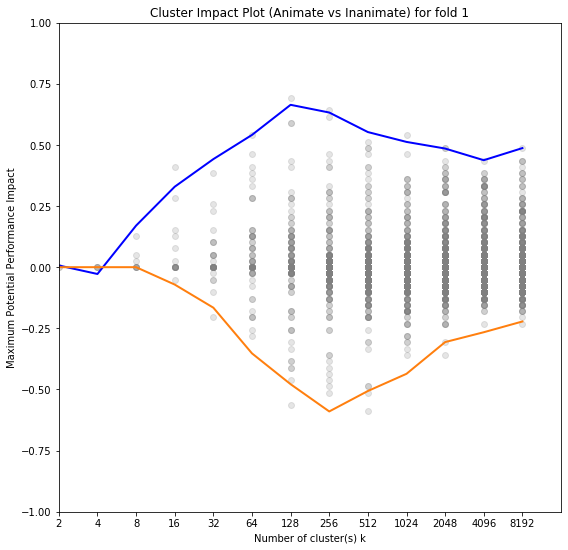

In [27]:
f = 1
clf_result = result[f]
from scipy.signal import savgol_filter

fig = plt.figure(1,figsize=(9,9))
X = range(1,14,1)
xticks = []
#X = range(2,51,1)
anat = []
inat = []
for cl in X:
    xticks.append(2**cl)
    i = 0
    temp = []
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'go',color='grey',alpha=0.2)
        temp.append(clf_result[cl][item])
        i += 1
    anat.append(np.max(temp))
    inat.append(np.min(temp))

ahat = savgol_filter(anat, 5, 3)
ihat =  savgol_filter(inat, 5, 3)       
plt.plot(X,ahat, color='b',linewidth=2)
plt.plot(X,ihat, color='C1',linewidth=2)
plt.ylim([-1,1])
plt.xlim([1,14])
plt.xticks(X,xticks)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Maximum Potential Performance Impact")
plt.title('Cluster Impact Plot (Animate vs Inanimate) for fold '+ str(f))
plt.axvline(x=23 , color='black', linestyle='--',alpha=0.3)
#plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))

plt.savefig('../../results/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=500)

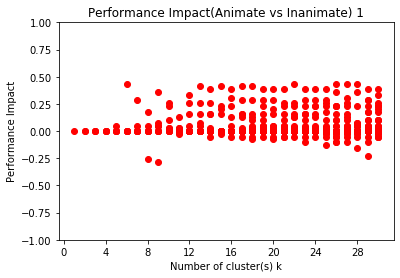

In [13]:
from matplotlib.ticker import MaxNLocator
f = 1
clf_result = result[f]


fig = plt.figure(1)
X = range(1,31,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.ylim([-1,1])
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact")
plt.title('Performance Impact(Animate vs Inanimate) '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/'+str(method)+'_results_fold_'+str(f)+'.eps', format='eps')

In [ ]:
f = 2
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

In [ ]:
f = 3
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

In [ ]:
f = 4
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

1 0.0 0.0
2 0.0 0.0
3 0.0 0.0
4 0.0 0.0
5 0.05128205128205132 0.0
6 0.4358974358974359 0.0
7 0.28205128205128205 0.0
8 0.17948717948717952 -0.2564102564102564
9 0.35897435897435903 -0.28205128205128205
10 0.2564102564102564 0.0
11 0.1282051282051282 -0.02564102564102566
12 0.33333333333333326 0.0
13 0.41025641025641024 0.0
14 0.3846153846153846 -0.05128205128205132
15 0.41025641025641024 -0.02564102564102566
16 0.3846153846153846 -0.05128205128205132
17 0.41025641025641024 -0.05128205128205132
18 0.41025641025641024 -0.07692307692307687
19 0.3846153846153846 -0.05128205128205132
20 0.3846153846153846 -0.07692307692307698
21 0.3846153846153846 -0.05128205128205132
22 0.4358974358974359 -0.05128205128205132
23 0.3846153846153846 -0.10256410256410253
24 0.3846153846153846 -0.05128205128205132
25 0.3846153846153846 -0.1282051282051282
26 0.4358974358974359 -0.10256410256410253
27 0.4358974358974359 -0.10256410256410253
28 0.4358974358974359 -0.15384615384615397
29 0.3846153846153846 -0.230

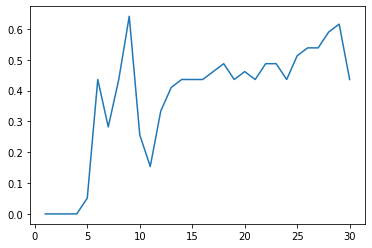

In [22]:
#Find MaxAd', MaxId' and its average
plt.figure()
noc = 1
for i in range(1,noc+1,1):
    X = []
    Y = []
    for j in range(1,31,1):
        X.append(j)
        temp = []
        for key, value in result[i][j].items():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        avg = float(maxa - maxi)
        Y.append(avg)
    #print X,Y
    plt.plot(X,Y)
print(Y.index(max(Y)), Y[8], Y[28])

In [15]:
#Smooth average graph
from scipy.interpolate import spline
noc = 4
flag = 0
X = range(2,51,1)
an_fold =[]
ian_fold = []
Y = []
for i in range(1,noc+1,1):
    if i == 2:
        flag = 1
    for j in range(2,51,1):
        temp = []
        for key, value in result[i][j].items():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        if flag == 0:
            an_fold.append(maxa)
            ian_fold.append(maxi)
        else:
            an_fold[j-2] += maxa
            ian_fold[j-2] = maxi

for j in range(2,51,1):
    maxa = (an_fold[j-2]) / 4.
    maxi = (ian_fold[j-2]) /4.
    diff = maxa - maxi
    Y.append(diff)
    
x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)

plt.plot(x_smooth, y_smooth, 'r', linewidth=1)
plt.plot(Y.index(max(Y))+1,max(Y),'o')
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Average Performance")
plt.savefig('../../results/scree/'+str(method)+'_results_fold_avg.png', format='png', dpi=200)
print(max(Y), Y.index(max(Y)) + 1)

ImportError: cannot import name 'spline' from 'scipy.interpolate' (/home/abhijit/anaconda3/envs/lesion/lib/python3.7/site-packages/scipy/interpolate/__init__.py)